In [3]:
# Basic dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial & Remote Sensing
import rasterio
from rasterio.plot import show
import geopandas as gpd
import rioxarray as rxr
import folium

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

# Others
import os
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

print("Dependencies loaded.")


Dependencies loaded.


In [4]:
# Load the training data from csv file and display the first few rows to inspect the data
# Load the dataset
file_path = "Training_data_uhi_index_2025-02-18.csv"  # Update with your local path
df = pd.read_csv(file_path)

In [5]:
# Convert datetime column to proper datetime format
df["datetime"] = pd.to_datetime(df["datetime"], format="%d-%m-%Y %H:%M")

# Remove exact duplicate rows
df_cleaned = df.drop_duplicates()

# Define valid NYC coordinate boundaries (approximate)
NYC_LAT_MIN, NYC_LAT_MAX = 40.5, 41.0
NYC_LON_MIN, NYC_LON_MAX = -74.3, -73.7

# Remove rows with out-of-bound coordinates
df_cleaned = df_cleaned[
    (df_cleaned["Latitude"].between(NYC_LAT_MIN, NYC_LAT_MAX)) &
    (df_cleaned["Longitude"].between(NYC_LON_MIN, NYC_LON_MAX))
]

# Detect outliers in UHI Index using IQR (Interquartile Range)
Q1 = df_cleaned["UHI Index"].quantile(0.25)
Q3 = df_cleaned["UHI Index"].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_cleaned = df_cleaned[(df_cleaned["UHI Index"] >= lower_bound) & (df_cleaned["UHI Index"] <= upper_bound)]

# Feature Engineering - Extract time features
df_cleaned["hour"] = df_cleaned["datetime"].dt.hour
df_cleaned["day"] = df_cleaned["datetime"].dt.day
df_cleaned["month"] = df_cleaned["datetime"].dt.month

# Normalize UHI Index (optional, useful for some ML models)
df_cleaned["UHI Index (Normalized)"] = (df_cleaned["UHI Index"] - df_cleaned["UHI Index"].mean()) / df_cleaned["UHI Index"].std()

# Save refined dataset
cleaned_file_path = "Training_data_uhi_index_refined.csv"
df_cleaned.to_csv(cleaned_file_path, index=False)

print(f"Cleaned dataset saved as: {cleaned_file_path}")
print(f"Removed {len(df) - len(df_cleaned)} rows (outliers + duplicates).")

Cleaned dataset saved as: Training_data_uhi_index_refined.csv
Removed 11 rows (outliers + duplicates).


In [6]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [7]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [8]:
# Define the time window
# We will use a period of 3 months to search for data
time_window = "2021-06-01/2021-09-01"

In [9]:
import pystac_client

# Connect to STAC API
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Define search parameters
search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["landsat-c2-l2"],  # Landsat Collection 2 Level 2
    query={
        "eo:cloud_cover": {"lt": 30},   # Less than 30% cloud cover
        "platform": {"in": ["landsat-8"]}, # Use Landsat 8 & 9
    }
)



In [10]:
# Retrieve results
items = list(search.get_items())
print(f"Found {len(items)} Landsat scenes.")

Found 7 Landsat scenes.


In [11]:
# Select a sample item
item = items[2]

# Print available assets
print(item.assets.keys())  # List all available bands


dict_keys(['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'mtl.txt', 'mtl.xml', 'mtl.json', 'qa_pixel', 'qa_radsat', 'qa_aerosol', 'tilejson', 'rendered_preview'])


In [12]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [13]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 30  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

For a general-purpose model, you might want to include bands that capture different aspects of the landscape, such as vegetation, water, and temperature. Here is a suggested selection of bands for training:

B02 (Blue)
B03 (Green)
B04 (Red)
B05 (NIR)
B06 (SWIR1)
B07 (SWIR2)
B11 (TIR1)
These bands provide a good mix of visible, near-infrared, shortwave infrared, and thermal infrared data, which can be useful for a variety of applications.

In [14]:
data = stac_load(
    items,
    bands=["blue", "green", "red", "nir08", "swir16", "swir22", "lwir11"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)
display(data)

<xarray.Dataset> Size: 26MB
Dimensions:      (latitude: 484, longitude: 558, time: 7)
Coordinates:
  * latitude     (latitude) float64 4kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 4kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 56B 2021-06-07T15:39:15.904901 ... 202...
Data variables:
    blue         (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    red          (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    nir08        (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    swir16       (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    swir22       (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    lwir11       (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>

In [15]:
# Persist the data in memory for faster operations
data = data.persist()

In [16]:
# Scale Factors for the RGB and NIR bands
scale_rgb_nir = 0.0000275
offset_rgb_nir = -0.2

# Scale Factors for the SWIR bands
scale_swir = 0.0000275
offset_swir = -0.2

# Scale Factors for the Thermal Infrared band
scale_tir = 0.00341802
offset_tir = 149.0
kelvin_celsius = 273.15  # convert from Kelvin to Celsius

# Apply scaling factors and offsets
data['blue'] = data['blue'].astype(float) * scale_rgb_nir + offset_rgb_nir
data['green'] = data['green'].astype(float) * scale_rgb_nir + offset_rgb_nir
data['red'] = data['red'].astype(float) * scale_rgb_nir + offset_rgb_nir
data['nir08'] = data['nir08'].astype(float) * scale_rgb_nir + offset_rgb_nir
data['swir16'] = data['swir16'].astype(float) * scale_swir + offset_swir
data['swir22'] = data['swir22'].astype(float) * scale_swir + offset_swir
data['lwir11'] = data['lwir11'].astype(float) * scale_tir + offset_tir - kelvin_celsius

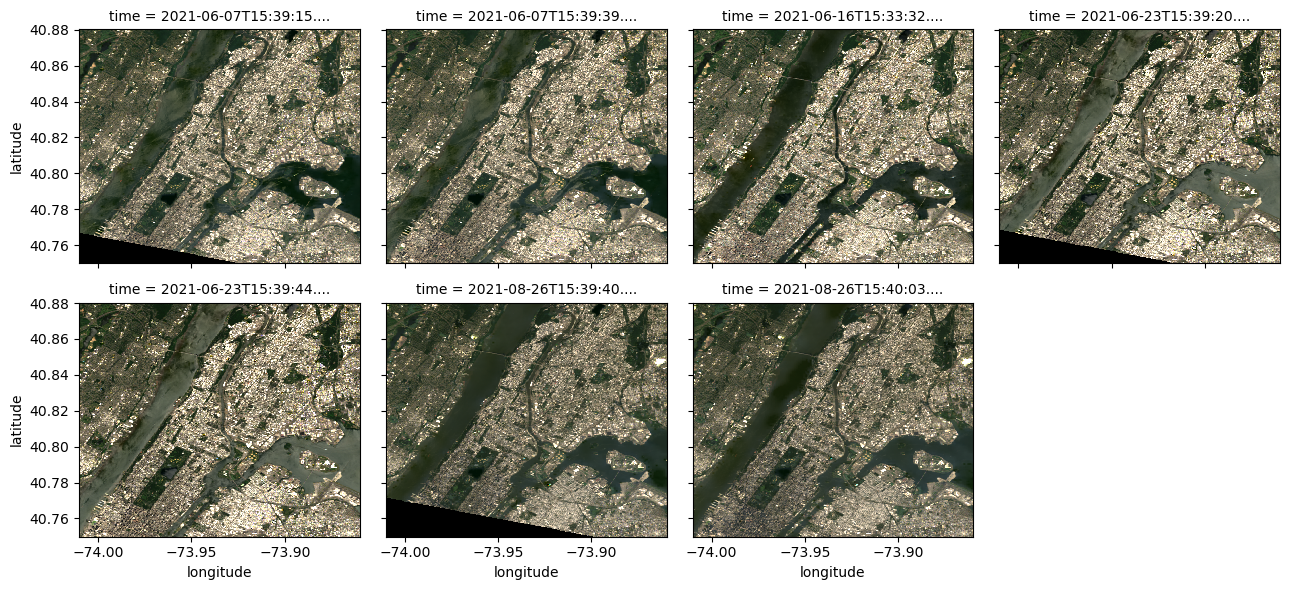

In [17]:
plot_data = data[["red","green","blue"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.25)
plt.show()

In [18]:
# Assuming 'items' is a list of scenes with metadata
# Select the scene with the lowest cloud cover
best_scene = min(items, key=lambda item: item.properties['eo:cloud_cover'])

# Get the index of the best scene
scene_index = items.index(best_scene)

# Print the selected scene index and its cloud cover
print(f"Selected scene index: {scene_index}")
print(f"Cloud cover: {best_scene.properties['eo:cloud_cover']}%")

# Use the selected scene index
scene = scene_index

# Now you can proceed with the rest of your code using the selected scene

Selected scene index: 6
Cloud cover: 6.88%


In [19]:
# Pick one of the scenes above (numbering starts with 0)
scene = 6

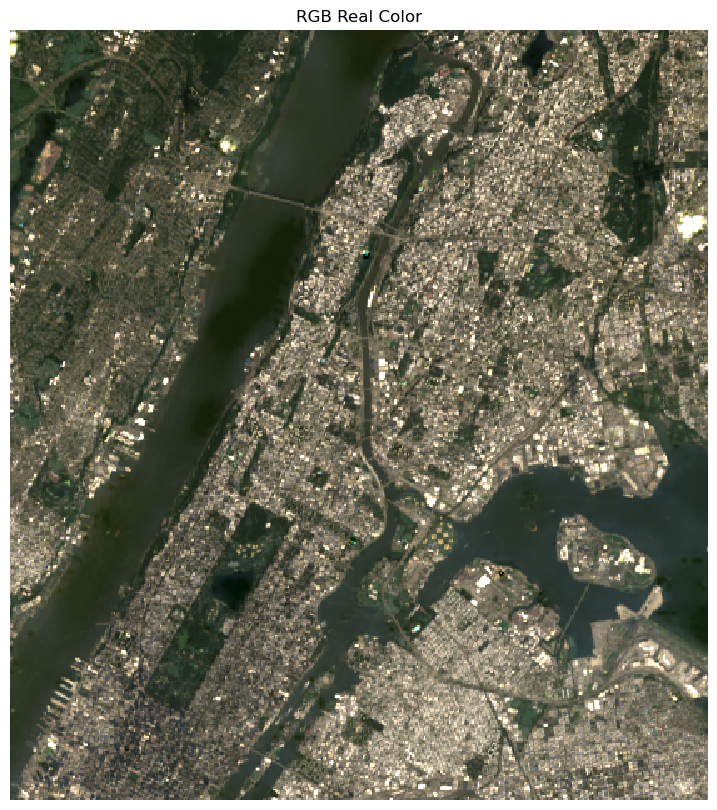

In [20]:
# Plot an RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(9,10))
data.isel(time=scene)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0.0, vmax=0.25)
ax.set_title("RGB Real Color")
ax.axis('off')
plt.show()

In [21]:
# Calculate NDVI for the median mosaic
ndvi_data = (data.isel(time=scene).nir08-data.isel(time=scene).red)/(data.isel(time=scene).nir08+data.isel(time=scene).red)

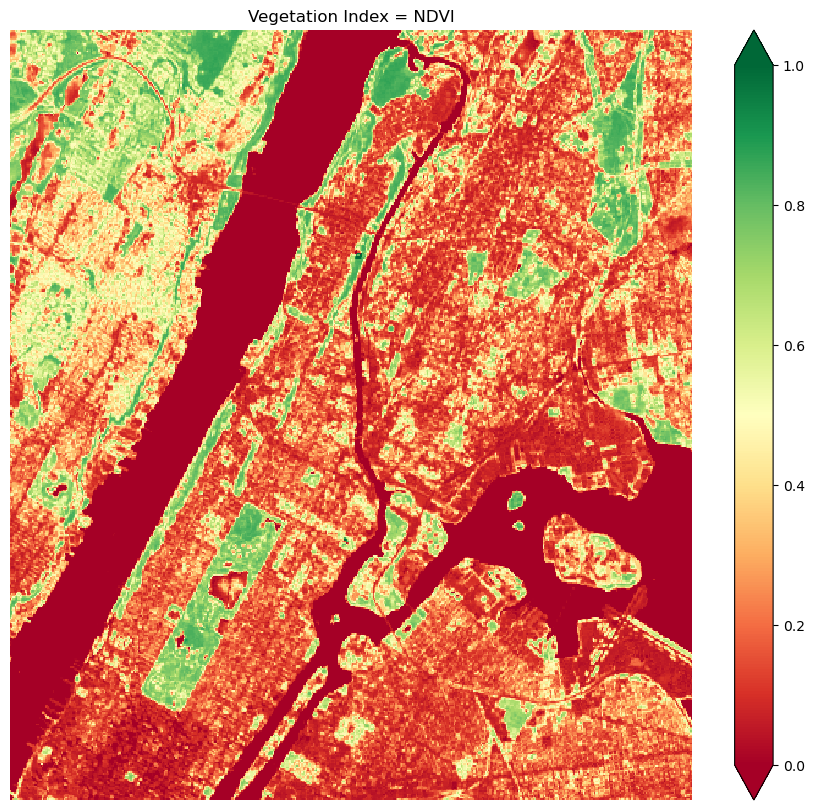

In [22]:
# Assuming 'scene' is the index of the selected scene
# Calculate NDVI for the selected scene
ndvi_data = (data.isel(time=scene).nir08 - data.isel(time=scene).red) / (data.isel(time=scene).nir08 + data.isel(time=scene).red)
ndvi_data = ndvi_data.where(np.isfinite(ndvi_data), 0)  # Replace infinities and NaNs with 0

# Plot the NDVI
fig, ax = plt.subplots(figsize=(11, 10))
ndvi_data.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn", ax=ax)
plt.title("Vegetation Index = NDVI")
plt.axis('off')
plt.show()

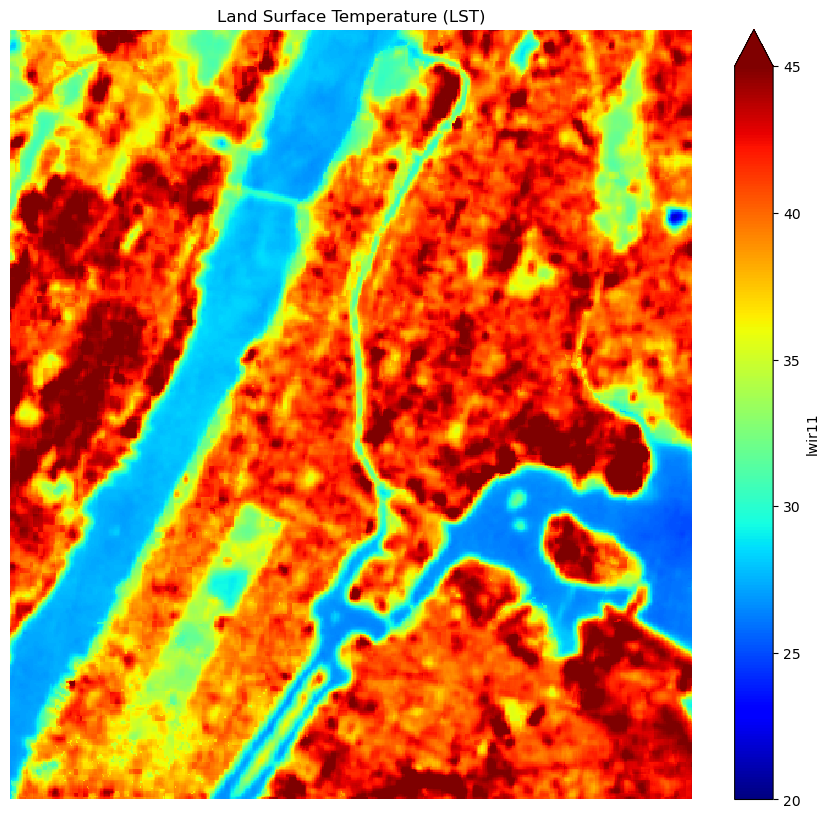

In [23]:
fig, ax = plt.subplots(figsize=(11,10))
data.isel(time=scene).lwir11.plot.imshow(vmin=20.0, vmax=45.0, cmap="jet")
plt.title("Land Surface Temperature (LST)")
plt.axis('off')
plt.show()

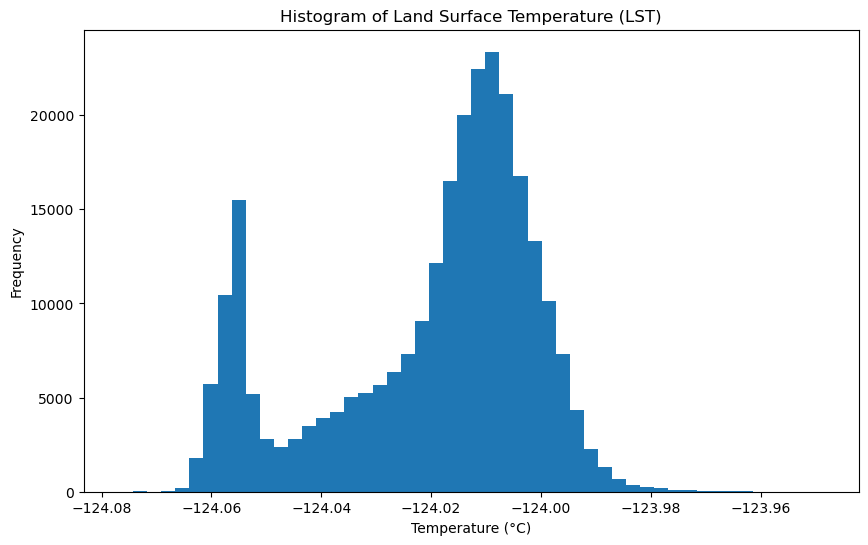

In [24]:
# Assuming 'scene' is the index of the selected scene
# Calculate LST for the selected scene
lst_data = data.isel(time=scene).lwir11.astype(float) * scale_tir + offset_tir - kelvin_celsius

# Ensure that the data is finite (no NaNs or infinities)
lst_data = lst_data.where(np.isfinite(lst_data), np.nan)

# Plot a histogram of the LST values
plt.figure(figsize=(10, 6))
lst_data.plot.hist(bins=50)
plt.title("Histogram of Land Surface Temperature (LST)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

In [25]:
# Only select one of the time slices to output
data3 = data.isel(time=scene)

In [26]:
filename = "Landsat_LST_Train.tiff"

In [27]:
# Calculate the dimensions of the file
height = data3.dims["latitude"]
width = data3.dims["longitude"]

In [28]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[0], lower_left[1], upper_right[0], upper_right[1], width, height)
data3.rio.write_crs("epsg:4326", inplace=True)
data3.rio.write_transform(transform=gt, inplace=True);

In [29]:
# Inspect the dimensions of data3
print(data3.dims)

# Assuming 'data3' contains the selected time slice with all the bands
# Define the file path for the output GeoTIFF
output_tiff_path = "Landsat_LST_Train.tiff"

# Define the transformation and CRS
transform = data3.rio.transform()
crs = data3.rio.crs

# Save the selected bands to the GeoTIFF file
with rasterio.open(
    output_tiff_path,
    'w',
    driver='GTiff',
    height=data3.sizes['latitude'],  # Use the correct dimension name
    width=data3.sizes['longitude'],  # Use the correct dimension name
    count=len(data3.data_vars),
    dtype=data3[list(data3.data_vars)[0]].dtype,  # Use the dtype of the first band
    crs=crs,
    transform=transform,
) as dst:
    for i, band in enumerate(data3.data_vars):
        dst.write(data3[band].values, i + 1)

print(f"GeoTIFF file saved with {len(data3.data_vars)} bands.")

FrozenMappingWarningOnValuesAccess({'latitude': 484, 'longitude': 558})
GeoTIFF file saved with 7 bands.


In [30]:
# Show the new saved output file
!ls *.tiff

Landsat_LST.tiff       Landsat_LST_Train.tiff S2_sample.tiff


In [31]:
# Open the GeoTIFF file and print the number of bands
tiff_path = "Landsat_LST_Train.tiff"

with rasterio.open(tiff_path) as src:
    print(f"Number of bands: {src.count}")
    print(f"Bands: {src.indexes}")

Number of bands: 7
Bands: (1, 2, 3, 4, 5, 6, 7)


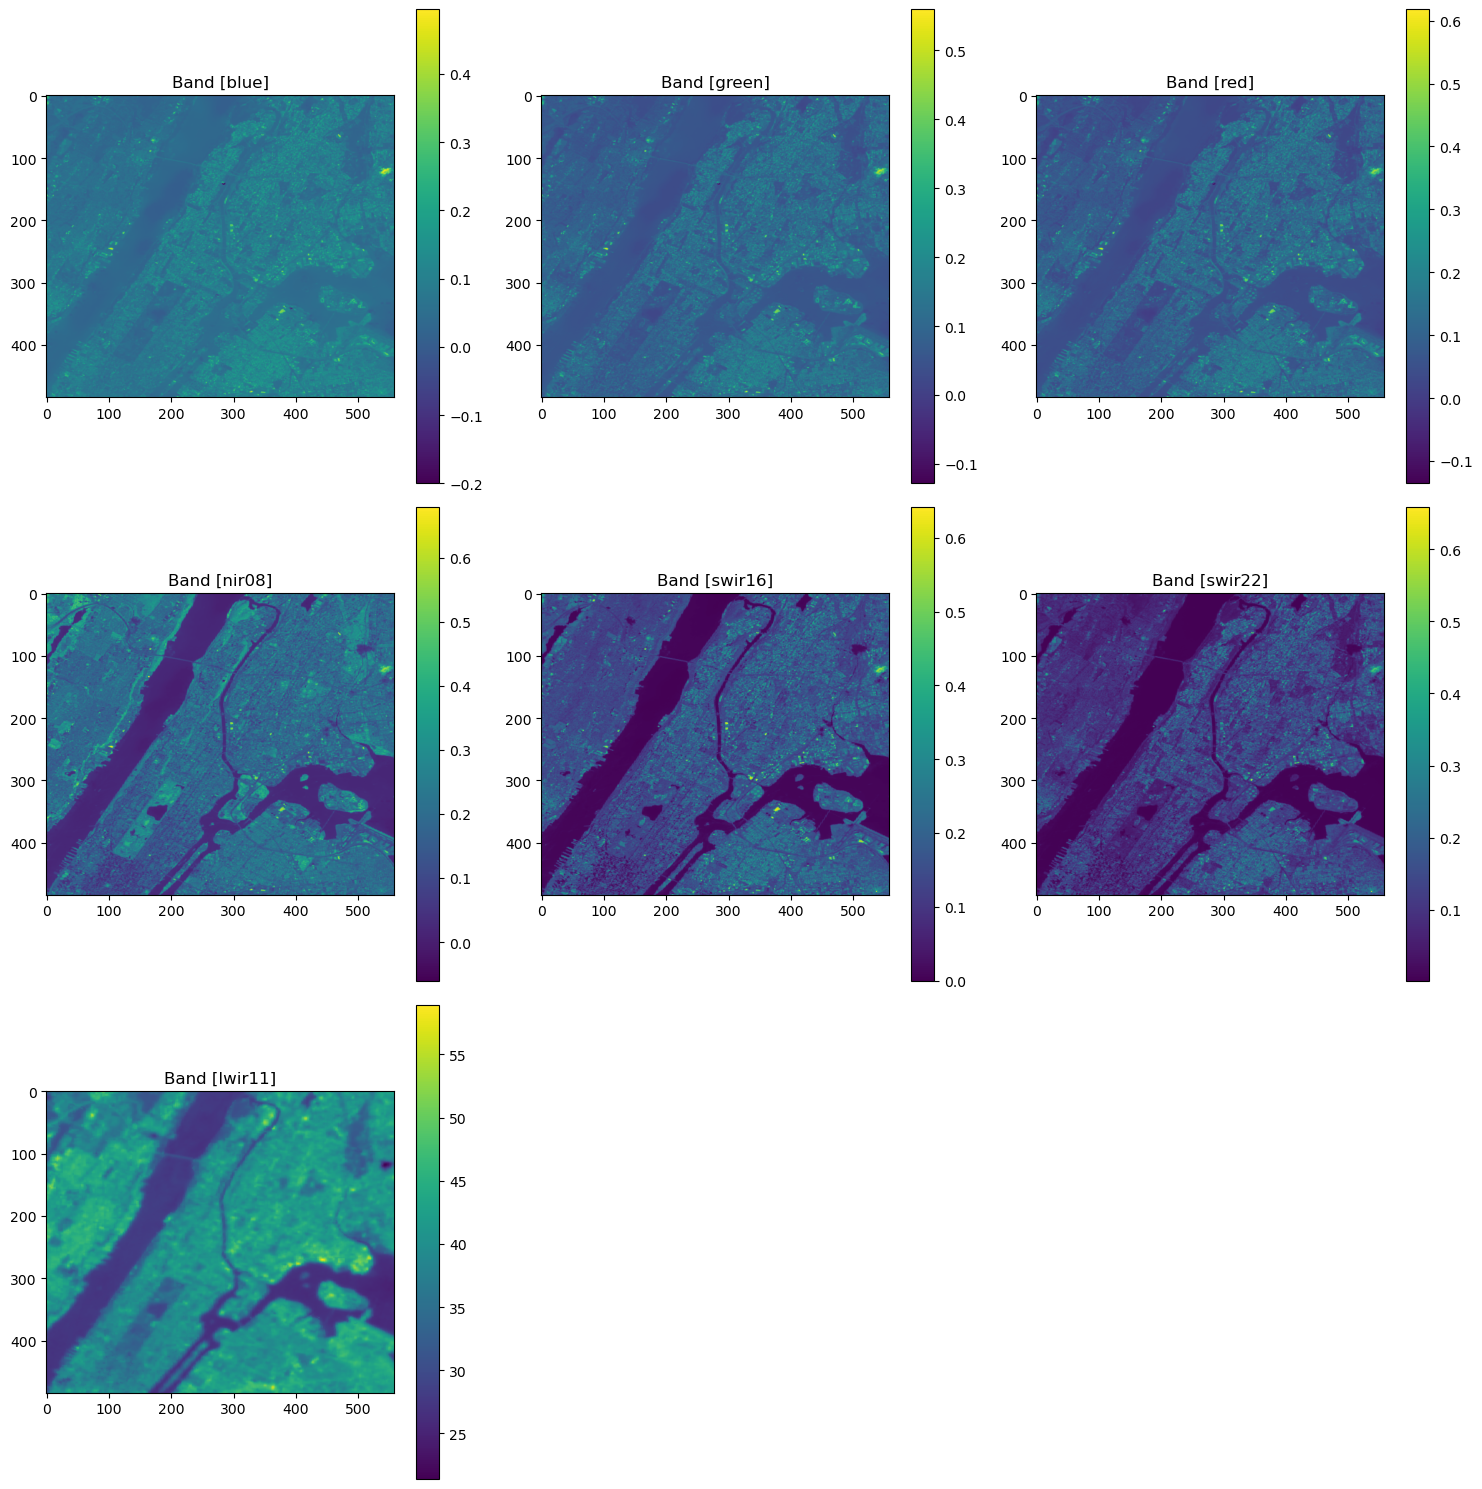

In [32]:
# Reads and plots selected bands from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = "Landsat_LST_Train.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src:
    blue_band = src.read(1)  # Band [blue]
    green_band = src.read(2)  # Band [green]
    red_band = src.read(3)  # Band [red]
    nir08_band = src.read(4)  # Band [nir08]
    swir16_band = src.read(5)  # Band [swir16]
    swir22_band = src.read(6)  # Band [swir22]
    lwir11_band = src.read(7)  # Band [lwir11]

# Plot the bands in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the bands
im1 = axes[0].imshow(blue_band, cmap='viridis')
axes[0].set_title('Band [blue]')
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(green_band, cmap='viridis')
axes[1].set_title('Band [green]')
fig.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(red_band, cmap='viridis')
axes[2].set_title('Band [red]')
fig.colorbar(im3, ax=axes[2])

im4 = axes[3].imshow(nir08_band, cmap='viridis')
axes[3].set_title('Band [nir08]')
fig.colorbar(im4, ax=axes[3])

im5 = axes[4].imshow(swir16_band, cmap='viridis')
axes[4].set_title('Band [swir16]')
fig.colorbar(im5, ax=axes[4])

im6 = axes[5].imshow(swir22_band, cmap='viridis')
axes[5].set_title('Band [swir22]')
fig.colorbar(im6, ax=axes[5])

im7 = axes[6].imshow(lwir11_band, cmap='viridis')
axes[6].set_title('Band [lwir11]')
fig.colorbar(im7, ax=axes[6])

# Hide the remaining empty subplots
for ax in axes[7:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [33]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.
def map_satellite_data(tiff_path, csv_path):
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Convert lat/long to the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    # Initialize lists to store band values
    blue_values = []
    green_values = []
    red_values = []
    nir08_values = []
    swir16_values = []
    swir22_values = []
    lwir11_values = []

    # Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
        blue_value = data.sel(x=lon, y=lat, band=1, method="nearest").values
        green_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        red_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        nir08_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        swir16_value = data.sel(x=lon, y=lat, band=5, method="nearest").values
        swir22_value = data.sel(x=lon, y=lat, band=6, method="nearest").values
        lwir11_value = data.sel(x=lon, y=lat, band=7, method="nearest").values

        blue_values.append(blue_value)
        green_values.append(green_value)
        red_values.append(red_value)
        nir08_values.append(nir08_value)
        swir16_values.append(swir16_value)
        swir22_values.append(swir22_value)
        lwir11_values.append(lwir11_value)

    # Create a DataFrame with the band values
    df = pd.DataFrame({
        'blue': blue_values,
        'green': green_values,
        'red': red_values,
        'nir08': nir08_values,
        'swir16': swir16_values,
        'swir22': swir22_values,
        'lwir11': lwir11_values
    })
    
    return df

# Example usage
tiff_path = "Landsat_LST_Train.tiff"
csv_path = "Training_data_uhi_index_refined.csv"
mapped_data = map_satellite_data(tiff_path, csv_path)
print(mapped_data.head())

Mapping values: 100%|██████████| 11218/11218 [00:22<00:00, 501.22it/s]


                  blue                green                  red    nir08  \
0  0.08627499999999999  0.10945749999999999  0.10896250000000002  0.24374   
1  0.08627499999999999  0.10945749999999999  0.10896250000000002  0.24374   
2  0.07142500000000002  0.09433249999999999             0.096725  0.27047   
3  0.07142500000000002  0.09433249999999999             0.096725  0.27047   
4  0.07142500000000002  0.09433249999999999             0.096725  0.27047   

                swir16               swir22              lwir11  
0             0.205075            0.1405325  42.782678780000026  
1             0.205075            0.1405325  42.782678780000026  
2  0.16827999999999999  0.09474500000000002  43.015104140000005  
3  0.16827999999999999  0.09474500000000002  43.015104140000005  
4  0.16827999999999999  0.09474500000000002  43.015104140000005  


In [34]:
# Mapping satellite data with training data.
final_data = map_satellite_data('Landsat_LST_Train.tiff', 'Training_data_uhi_index_refined.csv')

Mapping values: 100%|██████████| 11218/11218 [00:22<00:00, 499.61it/s]


In [35]:
final_data.head()

blue                green                  red    nir08  \
0  0.08627499999999999  0.10945749999999999  0.10896250000000002  0.24374   
1  0.08627499999999999  0.10945749999999999  0.10896250000000002  0.24374   
2  0.07142500000000002  0.09433249999999999             0.096725  0.27047   
3  0.07142500000000002  0.09433249999999999             0.096725  0.27047   
4  0.07142500000000002  0.09433249999999999             0.096725  0.27047   

                swir16               swir22              lwir11  
0             0.205075            0.1405325  42.782678780000026  
1             0.205075            0.1405325  42.782678780000026  
2  0.16827999999999999  0.09474500000000002  43.015104140000005  
3  0.16827999999999999  0.09474500000000002  43.015104140000005  
4  0.16827999999999999  0.09474500000000002  43.015104140000005

In [36]:
# Assuming 'mapped_data' contains the extracted band values and 'df' contains the original data with 'UHI Index'

# Combine the original data with the mapped satellite data
final_data = pd.concat([df, mapped_data], axis=1)

# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
final_data['NDVI'] = (final_data['nir08'] - final_data['red']) / (final_data['nir08'] + final_data['red'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan)
final_data['NDVI'] = final_data['NDVI'].fillna(0)  # Optionally replace NaNs with 0

# Include all relevant bands in the final dataset
final_data['blue'] = final_data['blue']
final_data['green'] = final_data['green']
final_data['red'] = final_data['red']
final_data['nir08'] = final_data['nir08']
final_data['swir16'] = final_data['swir16']
final_data['swir22'] = final_data['swir22']
final_data['lwir11'] = final_data['lwir11']

In [37]:
# Select relevant bands for model training
features = ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'lwir11', 'NDVI']  # Example feature selection
X = final_data[features]
y = final_data['UHI Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123)

In [38]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation R2 score: {best_score}")

# Train the model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_rf.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print(f"Test set R2 score: {test_r2}")

Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation R2 score: 0.7405363740160722
Test set R2 score: 0.7778369561258728


In [39]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [40]:
# Train the Random Forest model on the training data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [41]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

In [42]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.95548566231235

In [43]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

In [44]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.773898647673046

In [45]:
#Reading the coordinates for the submission
test_file = pd.read_csv('Submission_template.csv')
test_file.head()

Longitude   Latitude  UHI Index
0 -73.971665  40.788763        NaN
1 -73.971928  40.788875        NaN
2 -73.967080  40.789080        NaN
3 -73.972550  40.789082        NaN
4 -73.969697  40.787953        NaN

In [46]:
# Mapping satellite data for submission.
val_data = map_satellite_data('Landsat_LST_Train.tiff', 'Submission_template.csv')

Mapping values:   0%|          | 0/1040 [00:00<?, ?it/s]

Mapping values: 100%|██████████| 1040/1040 [00:02<00:00, 513.97it/s]


In [47]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
val_data['NDVI'] = (val_data['nir08'] - val_data['red']) / (val_data['nir08'] + val_data['red'])
val_data['NDVI'] = val_data['NDVI'].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN
val_data['NDVI'] = val_data['NDVI'].fillna(0)  # Optionally replace NaNs with 0

In [48]:
val_data.head()

blue                green                  red  \
0             0.127745              0.14397  0.15617999999999999   
1            0.1163325            0.1363525              0.14738   
2  0.08533999999999997  0.09785250000000001  0.10382000000000002   
3  0.06947249999999999  0.07860250000000002  0.07692500000000002   
4            0.1041225  0.12601250000000003            0.1367375   

                 nir08               swir16               swir22  \
0  0.19806250000000003            0.2125825             0.180545   
1              0.17994              0.20799  0.17977500000000002   
2  0.14427250000000003            0.1558775  0.13318999999999998   
3            0.1582425  0.12340000000000001  0.08443250000000002   
4  0.16935250000000002            0.2026825  0.17496250000000002   

               lwir11      NDVI  
0  41.114685020000024  0.118231  
1  40.311450320000006  0.099475  
2   40.43108102000002  0.163054  
3   40.41740894000003  0.345785  
4  43.456028720000006  0.106554

In [49]:
# Extracting specific columns (blue, green, red, nir08, swir16, swir22, lwir11, and NDVI) from the validation dataset
submission_val_data = val_data.loc[:, ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'lwir11', 'NDVI']]
submission_val_data.head()

blue                green                  red  \
0             0.127745              0.14397  0.15617999999999999   
1            0.1163325            0.1363525              0.14738   
2  0.08533999999999997  0.09785250000000001  0.10382000000000002   
3  0.06947249999999999  0.07860250000000002  0.07692500000000002   
4            0.1041225  0.12601250000000003            0.1367375   

                 nir08               swir16               swir22  \
0  0.19806250000000003            0.2125825             0.180545   
1              0.17994              0.20799  0.17977500000000002   
2  0.14427250000000003            0.1558775  0.13318999999999998   
3            0.1582425  0.12340000000000001  0.08443250000000002   
4  0.16935250000000002            0.2026825  0.17496250000000002   

               lwir11      NDVI  
0  41.114685020000024  0.118231  
1  40.311450320000006  0.099475  
2   40.43108102000002  0.163054  
3   40.41740894000003  0.345785  
4  43.456028720000006  0.106554

In [50]:
# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

In [51]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [52]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [53]:
#Displaying the sample submission dataframe
submission_df.head()

Longitude   Latitude  UHI Index
0 -73.971665  40.788763   0.961483
1 -73.971928  40.788875   0.965088
2 -73.967080  40.789080   0.978099
3 -73.972550  40.789082   0.978965
4 -73.969697  40.787953   0.961200

In [54]:
#Dumping the predictions into a csv file.
submission_df.to_csv("submission.csv",index = False)